In [1]:
import numpy as np
import pandas as pd
import sqlite3
import os

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import timedelta

from gaussfit import *

## Functions for channel mapping

In [2]:
def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_83_01/icarus_data/database/ChannelMapICARUS_20230829.db", table="pmt_placements_29aug2023"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)
    con.close()

    return df

def channel_to_PMTid(channels):
    
    geo = readSqlitedb()
    if np.isscalar(channels):
        pmt_id = geo[geo.channel_id==channels].pmt_id.values[0]
        return pmt_id
    else:
        pmt_ids = [ geo[geo.channel_id==ch].pmt_id.values[0] for ch in channels ] 
        return pmt_ids
    
def PMTid_to_channel(pmt_ids):
    
    geo = readSqlitedb()
    if np.isscalar(pmt_ids):
        channel = geo[geo.pmt_id==pmt_ids].channel_id.values[0]
        return channel
    else:
        channels = [ geo[geo.pmt_id==pmt].channel_id.values[0] for pmt in pmt_ids ] 
        return channels
    
def getCryo(channel):
    
    geo = readSqlitedb()
    board = geo[geo.channel_id==channel].digitizer_label.values[0]
    wall, pos, num = board.split("-")
    if wall[0] == "W":
        return 1
    elif wall[0] == "E":
        return 0
    
def getWall(channel):
    
    geo = readSqlitedb()
    wall = geo[geo.channel_id==channel].pmt_in_tpc_plane.values[0]
    return wall
    
def readPlacements(file="/exp/icarus/data/users/mvicenzi/pmt-calibration/input/pmt_positions.csv"):
    geo = pd.read_csv(file,sep=",")
    geo.drop(columns=["entry","subentry"],inplace=True)
    return geo

def getX(ch):
    geo = readPlacements()
    return geo["pmt_x"].iloc[ch]

def getY(ch):
    geo = readPlacements()
    return geo["pmt_y"].iloc[ch]

def getZ(ch):
    geo = readPlacements()
    return geo["pmt_z"].iloc[ch]

In [3]:
from scipy.optimize import curve_fit

def line(x, a, b ):
    return a*x+b

## Functions for data loading

In [4]:
# Get the timestamp
def getTimestamp(file):
    
    buff=file.split('_')
    timestamp = int(buff[-1].split('.')[0])
    
    return timestamp
    
# Get run number
def getRun(file):

    buff=file.split('_')
    run = int(buff[-2].lstrip("run"))

    return run

############################### DATA IMPORTER FUNCTIONS ###############################

def getOffChannels(file):
    r = getRun(file)
    offPMTs_uptoRUN2 = [1, 111, 143, 166, 192, 230, 238, 254, 222, 302, 309, 340, 353, 290 ]
    offPMTs_fromRUN3 = [143, 254, 290 ]

    if r>=11590:
        return PMTid_to_channel(offPMTs_fromRUN3)
    return PMTid_to_channel(offPMTs_uptoRUN2)

# Load a single file
def getDataFrame(file, timeseries=True, run=True):
   
    df=pd.read_csv(file, sep=',')
    
    # remove list of PMTs that are off
    offchs = getOffChannels(file)
    df= df[~df['pmt'].isin(offchs)]
    
    if timeseries:
        df["timestamp"] = getTimestamp(file)
        df['date'] = pd.to_datetime(df['timestamp'], unit='s')
        df.set_index("timestamp", inplace=True)
        
    if run:
        df["run"] = getRun(file)
    
    return df
    
def dataLoader(sourcedir = "../calibrationdb/", interval=(1610067905, 1637788392)):
        
    print("Import data in folder{} for interval ({}:{})".format(sourcedir, interval[0], interval[1]))
    
    # Load the data from the fit database
    data = pd.concat([ getDataFrame(sourcedir+file) for file in  os.listdir(sourcedir) if "backgroundphotons" in file ])
    # keep data only for the selected interval
    _sel = (data.index>=interval[0]) & (data.index<interval[1])
    # Sort the indeces by time
    data = data[_sel].sort_index()
    
    return data

###############################

def fitGains(x, run):
    BINSIZE=0.005; RMIN=0.0; RMAX=1.0; p0=(0.45, 0.02);
    
    nbins=int((RMAX-RMIN)/BINSIZE)
    p0 = (np.mean(x),0.02)

    ys,edges = np.histogram(x,bins=nbins,range=(RMIN,RMAX))
    xs=np.array([edges[i]+0.5*(edges[i+1]-edges[i]) for i in range(len(ys))])

    param = [np.max(ys), p0[0], p0[1] ]
    bounds = np.array([(param[0]*0.5,param[0]*1.5),
              (param[1]*0.2,param[1]*1.3),
              (param[2]*0.1,param[2]*1.4)])
    
    param,pcov = curve_fit(gaus, xs, ys, p0=param, bounds=(bounds[:,0],bounds[:,1]) )
    eparam = np.diag(pcov)**0.5
    equal, eEqual = getEqualization( param[1], param[2], param[2], eparam[2] )
    
    return param[1], param[2], equal, eEqual # returns mean_q, sigma, equal, eEqual

# Getting data for plotting

In [68]:
# Define source parameters 
sdir   = "/exp/icarus/data/users/mvicenzi/pmt-calibration/calibrationdb/"

trange = (1671100000, 1750000000)

# Import data between January 2024 and December 2024
#trange = (1707879481, 1724122681)
# Import data between December 2022 and December 2023
# trange = (1671100000, 1702598400)
# Import data between August 2021 and November 2021
# trange = (1627585983, 1636156757) # for pre-OB loss
# Import all available historical data
# trange = (1610067904,1702598400)

data = dataLoader(sdir, interval= trange)

Import data in folder/exp/icarus/data/users/mvicenzi/pmt-calibration/calibrationdb/ for interval (1671100000:1750000000)


In [69]:
# drop unneeded colums
data.drop(columns=['chi2', 'fitstatus','ndf','amplitude','eamplitude','sigma','esigma','mu','emu'], inplace=True)
data.reset_index(inplace=True)
data["cryo"] = data.pmt.apply(lambda x: getCryo(x))
data["wall"] = data.pmt.apply(lambda x: getWall(x))

In [70]:
dplot = data.groupby(["timestamp","date","run"]).agg(list).reset_index()
dplot[["mean_fit_q","fit_sigma","equal","eEqual"]] = dplot.apply(lambda x: fitGains(x["q"], x["run"]), axis=1, result_type='expand')

In [71]:
#dplot.head()

In [72]:
np.unique(dplot.run.to_numpy())

array([ 9271,  9342,  9383,  9384,  9448,  9499,  9598,  9627,  9724,
        9745,  9746,  9795,  9850,  9911,  9940,  9947, 10040, 10058,
       10097, 10165, 10197, 10263, 10313, 10464, 10536, 10606, 10712,
       10773, 10888, 10946, 11002, 11068, 11162, 11200, 11274, 11298,
       11342, 11377, 11418, 11456, 11508, 11562, 11590, 11631, 11693,
       11749, 11762, 11784, 11809, 11836, 11873, 11910, 11933, 11955,
       11958, 11973, 11988, 11991, 12014, 12024, 12037, 12044, 12138,
       12174, 12237, 12374, 12479, 12551, 12594, 12665, 12715, 12774,
       12777, 12837, 12844, 12873, 12910, 12923, 12935, 12959, 12970,
       12981, 12988, 12994, 13007, 13035, 13049, 13069, 13087, 13092,
       13102, 13109, 13114, 13122, 13123])

In [73]:
run1 = (pd.to_datetime("2022-06-08", utc=True).tz_localize(None),pd.to_datetime("2022-07-10", utc=True).tz_localize(None))
run2 = (pd.to_datetime("2022-12-20", utc=True).tz_localize(None),pd.to_datetime("2023-07-14", utc=True).tz_localize(None))
run3 = (pd.to_datetime("2024-03-14", utc=True).tz_localize(None),pd.to_datetime("2024-07-12", utc=True).tz_localize(None))
run4 = (pd.to_datetime("2024-12-10", utc=True).tz_localize(None),pd.to_datetime("2025-05-01", utc=True).tz_localize(None))

_selRUN1 = (dplot.date>=run1[0]) & (dplot.date<=run1[1])
_selRUN2 = (dplot.date>=run2[0]) & (dplot.date<=run2[1])
_selRUN3 = (dplot.date>=run3[0]) & (dplot.date<=run3[1])
_selRUN4 = (dplot.date>=run4[0]) & (dplot.date<=run4[1])

## Gain over time - single physics RUNs

In [74]:
def plot_average_gain(dplot, run, _selRUN, annotate=False):
    
    fig = plt.figure(figsize=(15, 5),dpi=200)
    
    # total gain loss
    qstart = dplot.loc[dplot[_selRUN]['timestamp'].idxmin(), 'mean_fit_q']
    qend = dplot.loc[dplot[_selRUN]['timestamp'].idxmax(), 'mean_fit_q']
    diff = qend-qstart
    perc = diff/qstart*100
    
    param,pcov = curve_fit(line, xdata=dplot[_selRUN].timestamp.to_numpy(), ydata=dplot[_selRUN].mean_fit_q.to_numpy(), sigma=dplot[_selRUN].fit_sigma.to_numpy())
    ys = line(dplot[_selRUN].timestamp.to_numpy(),param[0],param[1])

    month_in_s = 30*24*60*60
    day_in_s = 24*60*60
    month_loss = param[0]*month_in_s/qstart*100
    day_loss = param[0]*day_in_s/qstart*100

    print("Monthly loss: RUN-{} {:.4f}%".format(run, month_loss))
    print("Daily loss:   RUN-{} {:.4f}%".format(run, day_loss))

    plt.plot( dplot[_selRUN].date.to_numpy(), ys, color="red", lw=2, label="RUN-{} linear fit:\n$-${:.2f}%/month".format(run,-1*month_loss))
    plt.errorbar( x=dplot[_selRUN].date, y=dplot[_selRUN].mean_fit_q, yerr=dplot[_selRUN].fit_sigma, fmt='o',
             label="Mean PMT gain\nRUN-{} total loss: {:.2f}%".format(run,perc))

    if(annotate):
        for i,r in enumerate(dplot[_selRUN].run.to_numpy()):
            plt.annotate( str(r), xy=(dplot[_selRUN].date.to_numpy()[i],dplot[_selRUN].mean_fit_q.to_numpy()[i]),textcoords="offset points", xytext=(0,22), ha='center')

    #plt.ylim((0.35,0.43))
    plt.ylabel("Gain [$10^7$ electrons]", fontsize=12)
    plt.title("ICARUS RUN-{} Average PMT Gain".format(run), fontsize=14)
    plt.grid(alpha=0.5, linestyle="dashed")
    #plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right", fontsize=12)
    plt.gcf().autofmt_xdate()
    
    plt.legend(fontsize=12,ncol=2)

    name = "figs/ICARUS_RUN-{}_average_PMT_gain_fit.pdf".format(run)
    plt.savefig(name,dpi=200)
    
    plt.show()

In [75]:
def plot_gain_equalization(dplot,run,_selRUN,annotate=False):
    
    fig = plt.figure(figsize=(15, 4.8),dpi=200)

    plt.errorbar( x=dplot[_selRUN].date, y=dplot[_selRUN].equal*100, yerr=dplot[_selRUN].eEqual*100, fmt='o')
    
    if annotate:
        for i,r in enumerate(dplot[_selRUN].run.to_numpy()):
            plt.annotate( str(r), xy=(dplot[_selRUN].date.to_numpy()[i],dplot[_selRUN].equal.to_numpy()[i]*100),textcoords="offset points", xytext=(0,17), ha='center')

    #plt.ylim((1.,2.))
    plt.ylabel("Equalization [%]", fontsize=12)
    plt.title("ICARUS RUN-{} PMT Gain Equalization".format(run), fontsize=14)
    plt.grid(alpha=0.5, linestyle="dashed")
    #plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right", fontsize=12)
    #plt.legend(fontsize=12)
    plt.gcf().autofmt_xdate()

    name = "figs/ICARUS_RUN-{}_PMT_equalization.pdf".format(run)
    #plt.savefig(name,dpi=300)
    plt.show()

### Run-1

In [76]:
#plot_average_gain(dplot, 1, _selRUN1, annotate=False)
#plot_gain_equalization(dplot,1,_selRUN1,annotate=False)

### Run-2

In [77]:
#plot_average_gain(dplot, 2, _selRUN2, annotate=False)
#plot_gain_equalization(dplot,2,_selRUN2,annotate=False)

### Run-3

In [78]:
#plot_average_gain(dplot, 3, _selRUN3, annotate=False)
#plot_gain_equalization(dplot,3,_selRUN3,annotate=False)

### Run-4

Monthly loss: RUN-4 -0.3054%
Daily loss:   RUN-4 -0.0102%


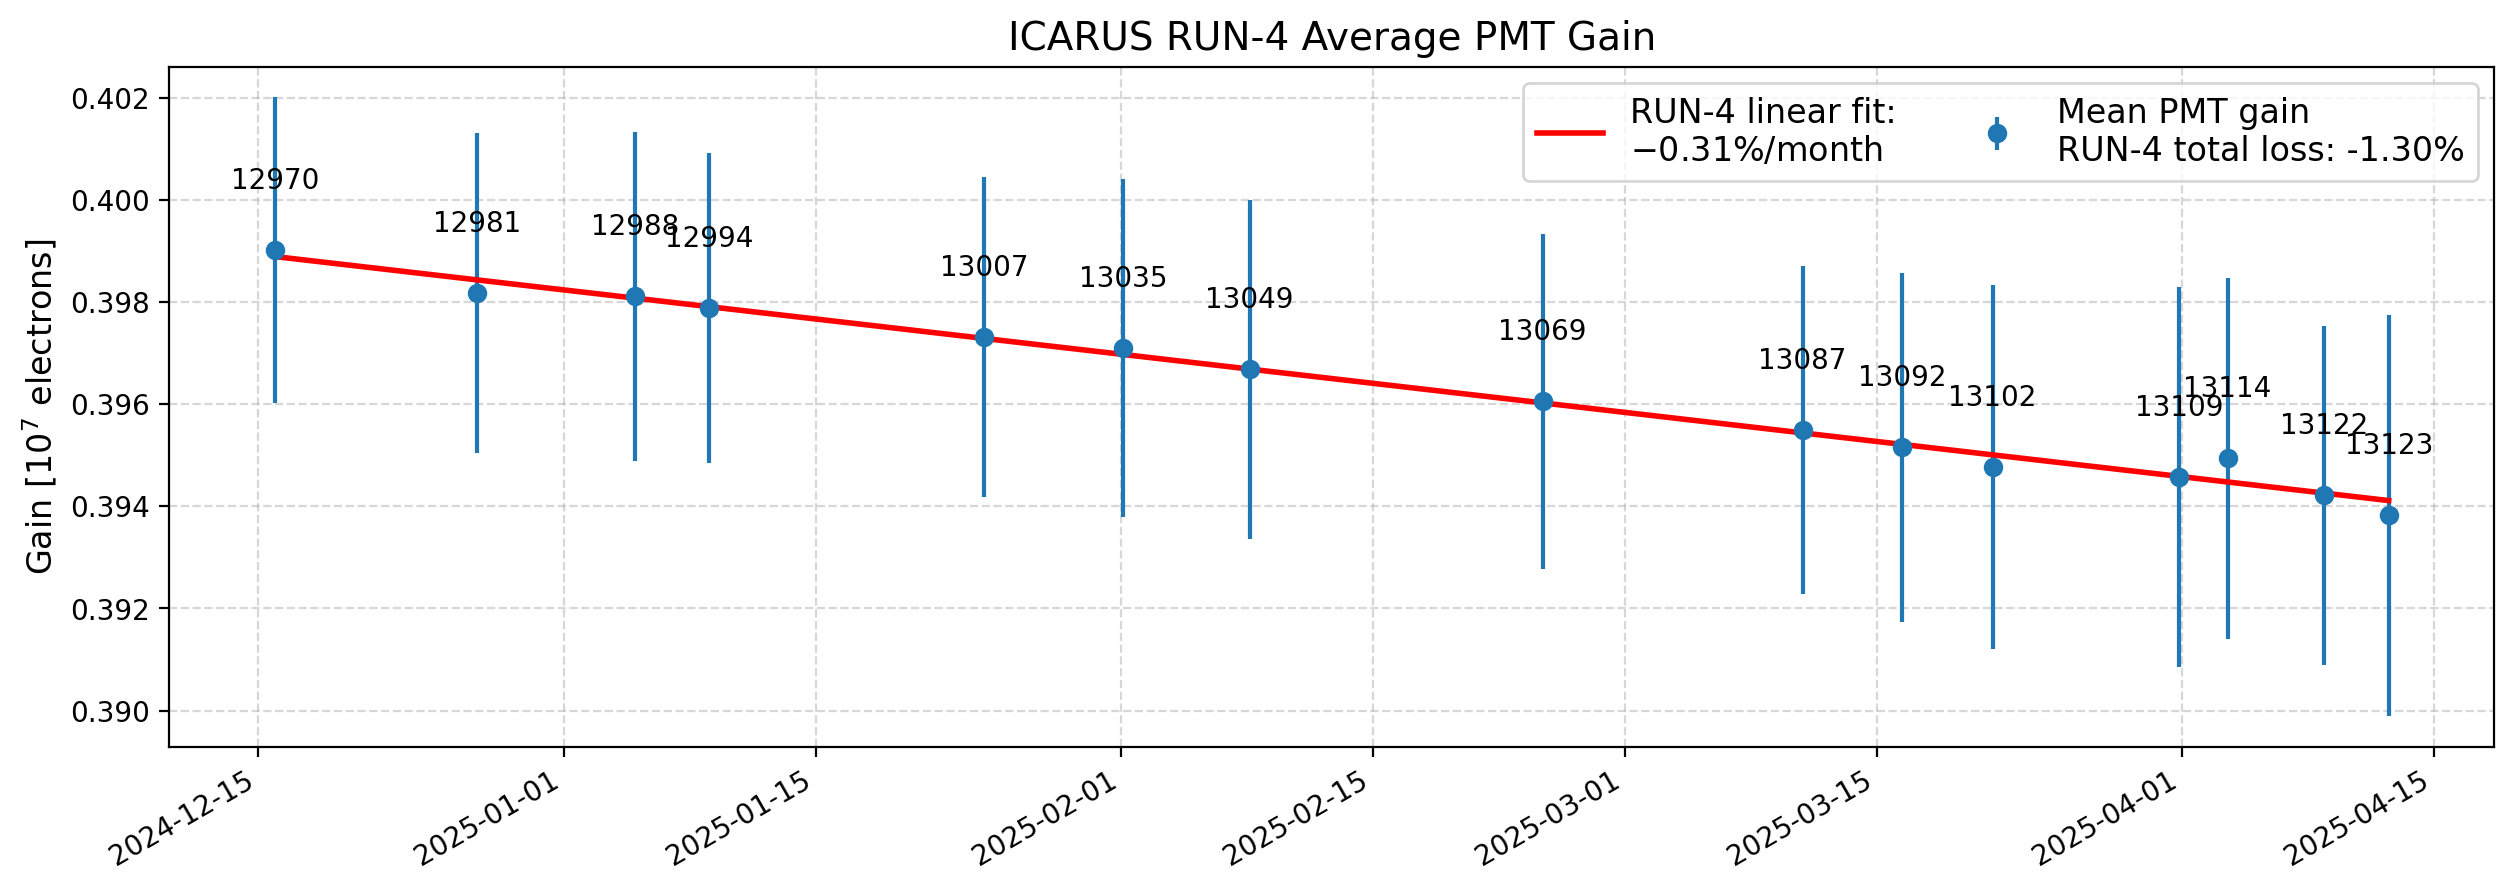

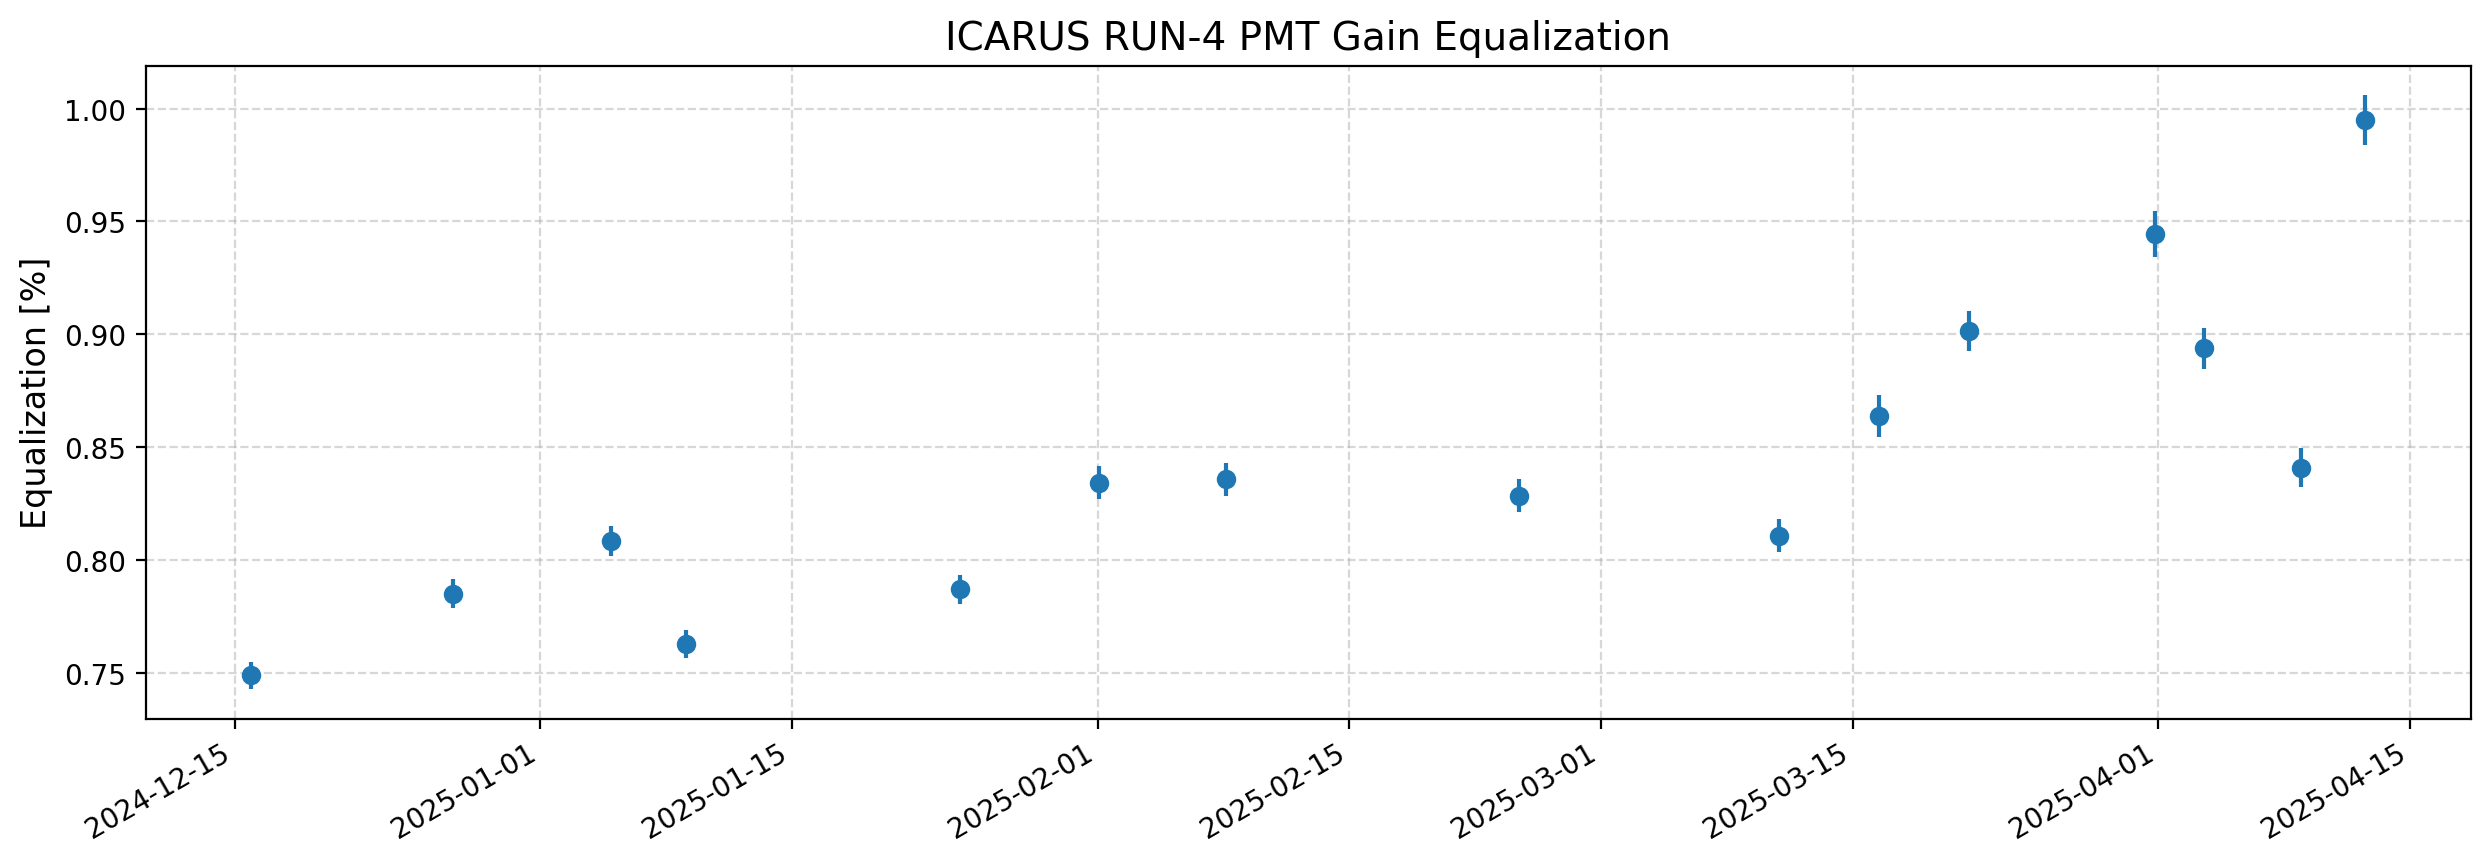

In [79]:
plot_average_gain(dplot, 4, _selRUN4, annotate=True)
plot_gain_equalization(dplot,4,_selRUN4,annotate=False)

## Gain over time - all RUNs

In [80]:
bad_runs = [10263, 10313, 10464, 10536, 10888, 10773, 10606, 10712]
_selQ = ~dplot['run'].isin(bad_runs)

Monthly loss: RUN-2 -0.6573%, RUN-3 -0.2830%
Daily loss:   RUN-2 -0.0219%, RUN-3 -0.0094%%
Monthly loss: RUN-4 -0.3054%
Daily loss:   RUN-4 -0.0102%%


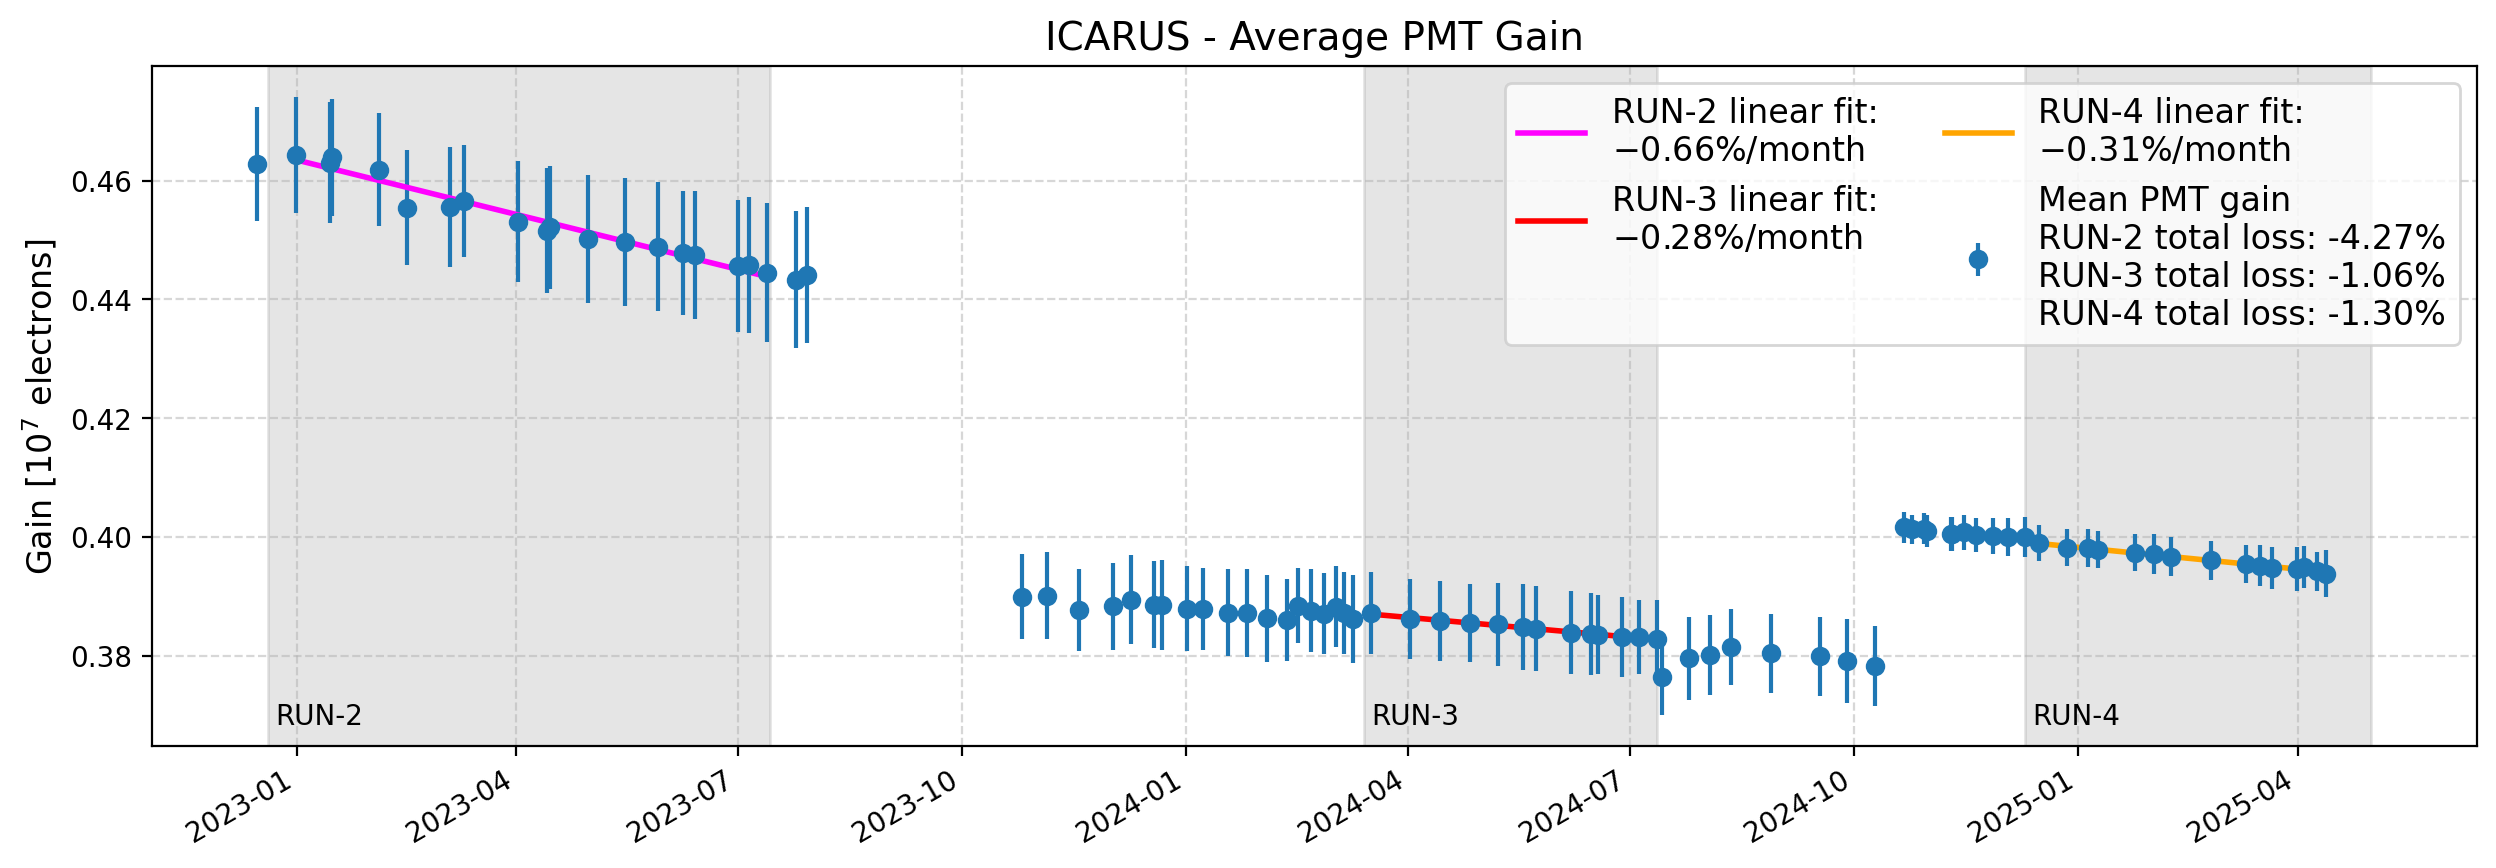

In [81]:
fig = plt.figure(figsize=(15, 5),dpi=200)

# total gain loss
qstart = dplot.loc[dplot[_selRUN2]['timestamp'].idxmin(), 'mean_fit_q']
qend = dplot.loc[dplot[_selRUN2]['timestamp'].idxmax(), 'mean_fit_q']
diff = qend-qstart
perc = diff/qstart*100

qstart1 = dplot.loc[dplot[_selRUN3]['timestamp'].idxmin(), 'mean_fit_q']
qend1 = dplot.loc[dplot[_selRUN3]['timestamp'].idxmax(), 'mean_fit_q']
diff1 = qend1-qstart1
perc1 = diff1/qstart1*100

qstart2 = dplot.loc[dplot[_selRUN4]['timestamp'].idxmin(), 'mean_fit_q']
qend2 = dplot.loc[dplot[_selRUN4]['timestamp'].idxmax(), 'mean_fit_q']
diff2 = qend2-qstart2
perc2 = diff2/qstart2*100

param,pcov = curve_fit(line, xdata=dplot[_selRUN2].timestamp.to_numpy(), ydata=dplot[_selRUN2].mean_fit_q.to_numpy(), sigma=dplot[_selRUN2].fit_sigma.to_numpy())
ys = line(dplot[_selRUN2].timestamp.to_numpy(),param[0],param[1])

param1,pcov1 = curve_fit(line, xdata=dplot[_selRUN3].timestamp.to_numpy(), ydata=dplot[_selRUN3].mean_fit_q.to_numpy(), sigma=dplot[_selRUN3].fit_sigma.to_numpy())
ys1 = line(dplot[_selRUN3].timestamp.to_numpy(),param1[0],param1[1])

param2,pcov2 = curve_fit(line, xdata=dplot[_selRUN4].timestamp.to_numpy(), ydata=dplot[_selRUN4].mean_fit_q.to_numpy(), sigma=dplot[_selRUN4].fit_sigma.to_numpy())
ys2 = line(dplot[_selRUN4].timestamp.to_numpy(),param2[0],param2[1])

month_in_s = 30*24*60*60
day_in_s = 24*60*60

month_loss = param[0]*month_in_s/qstart*100
day_loss = param[0]*day_in_s/qstart*100
month_loss1 = param1[0]*month_in_s/qstart1*100
day_loss1 = param1[0]*day_in_s/qstart1*100
month_loss2 = param2[0]*month_in_s/qstart2*100
day_loss2 = param2[0]*day_in_s/qstart2*100

print("Monthly loss: RUN-2 {:.4f}%, RUN-3 {:.4f}%".format(month_loss, month_loss1))
print("Daily loss:   RUN-2 {:.4f}%, RUN-3 {:.4f}%%".format(day_loss, day_loss1))
print("Monthly loss: RUN-4 {:.4f}%".format(month_loss2))
print("Daily loss:   RUN-4 {:.4f}%%".format(day_loss2))

plt.plot( dplot[_selRUN2].date.to_numpy(), ys, color="magenta", lw=2, label="RUN-2 linear fit:\n$-${:.2f}%/month".format(-1*month_loss))
plt.plot( dplot[_selRUN3].date.to_numpy(), ys1, color="red", lw=2, label="RUN-3 linear fit:\n$-${:.2f}%/month".format(-1*month_loss1))
plt.plot( dplot[_selRUN4].date.to_numpy(), ys2, color="orange", lw=2, label="RUN-4 linear fit:\n$-${:.2f}%/month".format(-1*month_loss2))

plt.errorbar( x=dplot[_selQ].date, y=dplot[_selQ].mean_fit_q, yerr=dplot[_selQ].fit_sigma, fmt='o',
             label="Mean PMT gain\nRUN-2 total loss: {:.2f}%\nRUN-3 total loss: {:.2f}%\nRUN-4 total loss: {:.2f}%".format(perc,perc1,perc2))
#plt.errorbar( x=dplot.date, y=dplot.mean_fit_q, yerr=dplot.fit_sigma, fmt='o',label="Mean PMT gain\nRUN-3 total loss: {:.2f}%".format(perc1))

#for i,r in enumerate(dplot[_selQ].run.to_numpy()):
#    plt.annotate( str(r), xy=(dplot[_selQ].date.to_numpy()[i],dplot[_selQ].mean_fit_q.to_numpy()[i]),textcoords="offset points", xytext=(0,22), ha='center')

#plt.ylim((0.35,0.43))
plt.ylabel("Gain [$10^7$ electrons]", fontsize=12)
plt.title("ICARUS - Average PMT Gain", fontsize=14)
plt.grid(alpha=0.5, linestyle="dashed")
#plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right", fontsize=12)
plt.gcf().autofmt_xdate()

plt.legend(fontsize=12, ncol=2)

ybot = plt.gca().get_ylim()[0]  # Get the lower limit of the y-axis

# Run1 
#plt.axvline( x=run1[0], linestyle="dashed",color="black")
#plt.axvline( x=run1[1], linestyle="dashed",color="black")

# Run2
#plt.axvline(x=pd.to_datetime("2022-12-13", utc=True).tz_localize(None), linestyle="dashed",color="black")
#plt.text(x=pd.to_datetime("2022-12-13", utc=True).tz_localize(None)-timedelta(days=9), y=0.99*ytop, s='Gain equalization', rotation=90, fontsize=8, va="top")
#plt.axvline( x=run2[0], linestyle="dashed",color="black")
#plt.axvline( x=run2[1], linestyle="dashed",color="black")
plt.axvspan(run2[0], run2[1], color="gray", alpha=0.2)
plt.text(x=run2[0]+timedelta(days=3), y=1.02*ybot, s='RUN-2', rotation=0, fontsize=10, va="top")
#plt.text(x=run2[1]+timedelta(days=3), y=0.99*ytop, s='End RUN-2', rotation=90, fontsize=8, va="top")

# Run3
#plt.axvline(x=pd.to_datetime("2023-08-07", utc=True).tz_localize(None), linestyle="dashed",color="black")
#plt.text(x=pd.to_datetime("2023-08-07", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='New WEST cables', rotation=90,fontsize=8, va="top")
#plt.axvline(x=pd.to_datetime("2023-09-18", utc=True).tz_localize(None), linestyle="dashed",color="black")
#plt.text(x=pd.to_datetime("2023-09-18", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='WEST equalization', rotation=90,fontsize=8, va="top")
#plt.axvline(x=pd.to_datetime("2023-10-11", utc=True).tz_localize(None), linestyle="dashed",color="black")
#plt.text(x=pd.to_datetime("2023-10-11", utc=True).tz_localize(None)-timedelta(days=9), y=0.99*ytop, s='New EAST cables', rotation=90,fontsize=8, va="top")
#plt.axvline(x=pd.to_datetime("2023-10-18", utc=True).tz_localize(None), linestyle="dashed",color="black")
#plt.text(x=pd.to_datetime("2023-10-18", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='Gain equalization', rotation=90,fontsize=8, va="top")
#plt.axvline(x=pd.to_datetime("2024-02-15", utc=True).tz_localize(None), linestyle="dashed",color="black")
#plt.text(x=pd.to_datetime("2024-02-15", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='Gain equalization', rotation=90,fontsize=8, va="top")
#plt.axvline( x=run3[0], linestyle="dashed",color="black")
#plt.axvline( x=run3[1], linestyle="dashed",color="black")
plt.axvspan(run3[0], run3[1], color="gray", alpha=0.2)
plt.text(x=run3[0]+timedelta(days=3), y=1.02*ybot, s='RUN-3', rotation=0, fontsize=10, va="top")
#plt.text(x=run3[1]+timedelta(days=3), y=0.99*ytop, s='RUN-3', rotation=90, fontsize=8, va="top")

# Run 4
#plt.axvline(x=pd.to_datetime("2024-10-21", utc=True).tz_localize(None), linestyle="dashed",color="black")
#plt.text(x=pd.to_datetime("2024-10-21", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='Gain equalization', rotation=90, fontsize=8, va="top")
#plt.axvline(x=run4[0], linestyle="dashed",color="black")
plt.axvspan(run4[0], run4[1], color="gray", alpha=0.2)
plt.text(x=run4[0]+timedelta(days=3), y=1.02*ybot, s='RUN-4', rotation=0, fontsize=10, va="top")

name = "figs/ICARUS_Mean_PMT_gain_fit"
plt.savefig(name+".pdf",dpi=300)
plt.show()

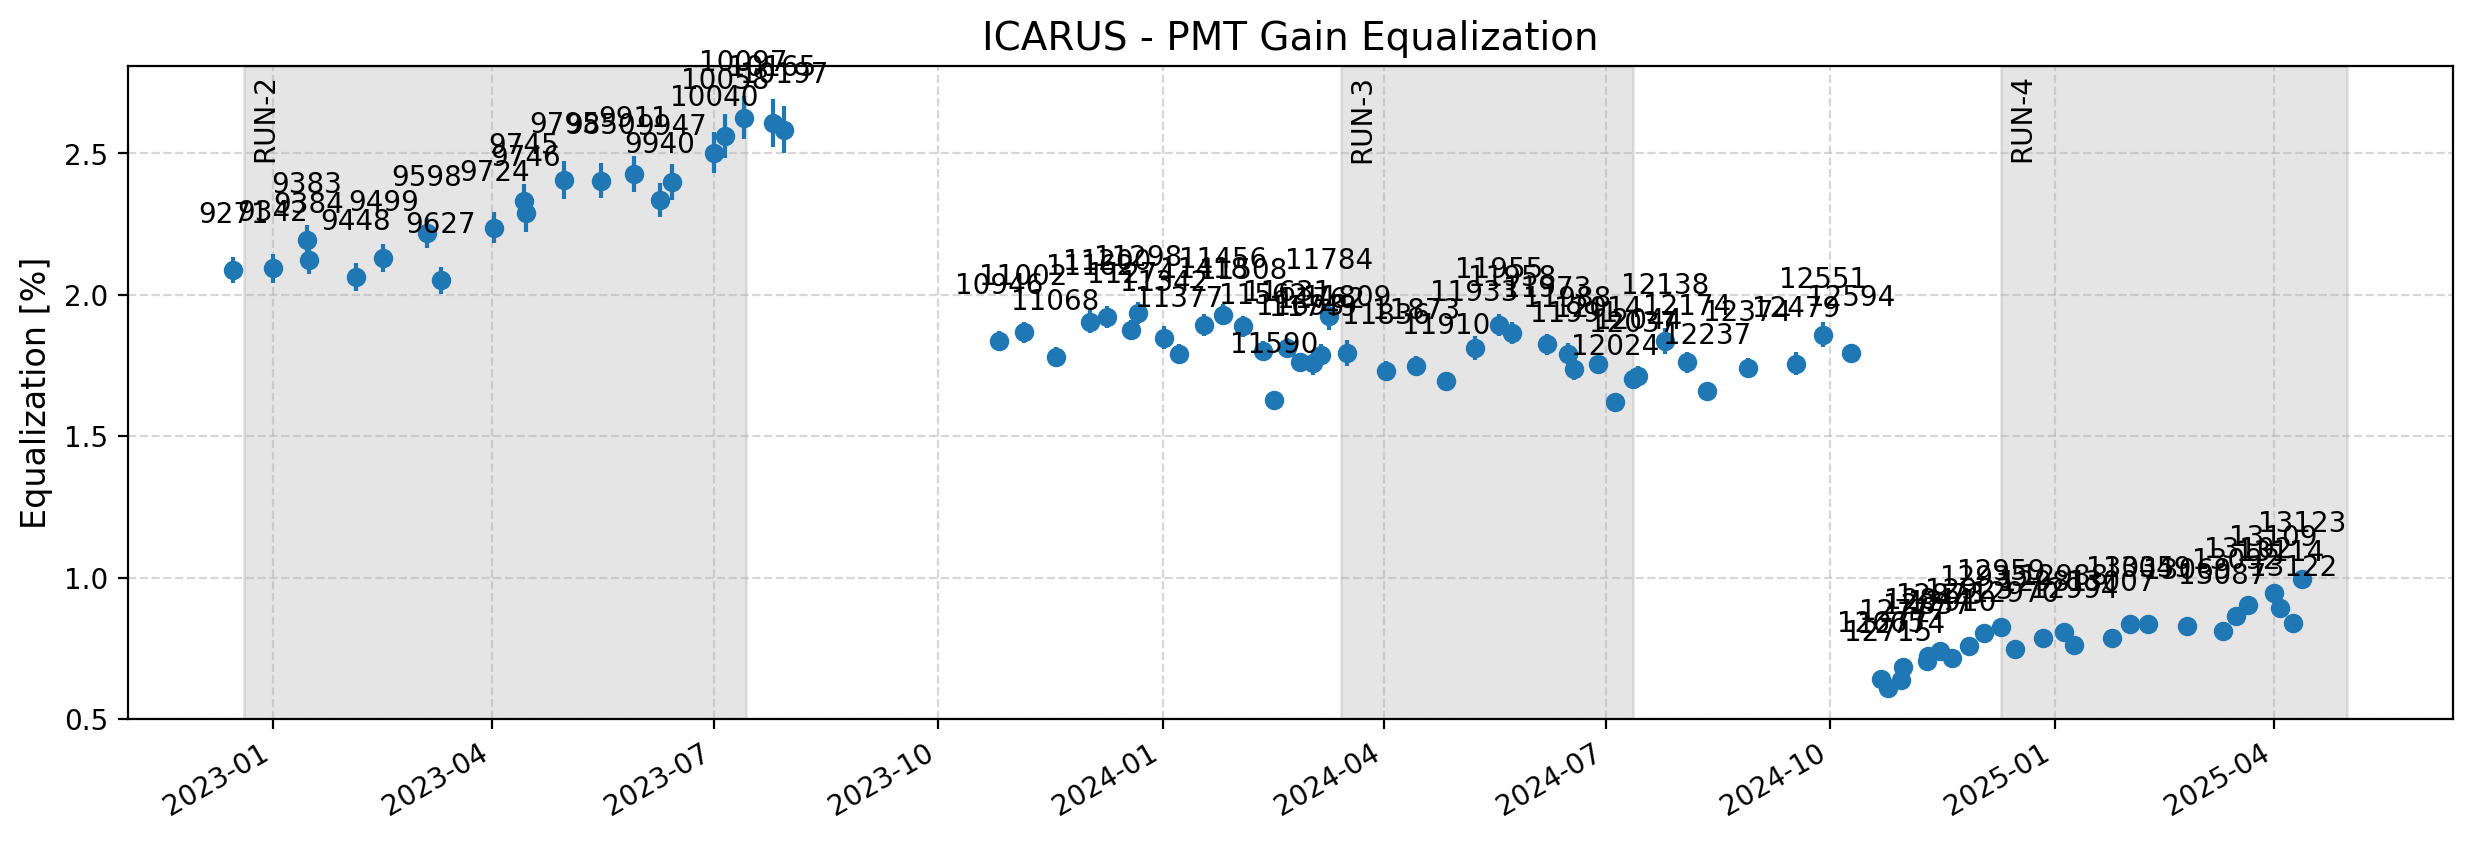

In [82]:
fig = plt.figure(figsize=(15, 4.8),dpi=200)

plt.errorbar( x=dplot[_selQ].date, y=dplot[_selQ].equal*100, yerr=dplot[_selQ].eEqual*100, fmt='o')
for i,r in enumerate(dplot[_selQ].run.to_numpy()):
    plt.annotate( str(r), xy=(dplot[_selQ].date.to_numpy()[i],dplot[_selQ].equal.to_numpy()[i]*100),textcoords="offset points", xytext=(0,17), ha='center')

#plt.ylim((1.,2.))
plt.ylabel("Equalization [%]", fontsize=12)
plt.title("ICARUS - PMT Gain Equalization", fontsize=14)
plt.grid(alpha=0.5, linestyle="dashed")
#plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right", fontsize=12)
#plt.legend(fontsize=12)
plt.gcf().autofmt_xdate()

ytop = plt.gca().get_ylim()[1]  # Get the upper limit of the y-axis

# Run1 
#plt.axvline( x=run1[0], linestyle="dashed",color="black")
#plt.axvline( x=run1[1], linestyle="dashed",color="black")

# Run2
#plt.axvline(x=pd.to_datetime("2022-12-13", utc=True).tz_localize(None), linestyle="dashed",color="black")
#plt.text(x=pd.to_datetime("2022-12-13", utc=True).tz_localize(None)-timedelta(days=9), y=0.99*ytop, s='Gain equalization', rotation=90, fontsize=8, va="top")
#plt.axvline( x=run2[0], linestyle="dashed",color="black")
#plt.axvline( x=run2[1], linestyle="dashed",color="black")
plt.axvspan(run2[0], run2[1], color="gray", alpha=0.2)
plt.text(x=run2[0]+timedelta(days=3), y=0.99*ytop, s='RUN-2', rotation=90, fontsize=10, va="top")
#plt.text(x=run2[1]+timedelta(days=3), y=0.99*ytop, s='End RUN-2', rotation=90, fontsize=8, va="top")

# Run3
#plt.axvline(x=pd.to_datetime("2023-08-07", utc=True).tz_localize(None), linestyle="dashed",color="black")
#plt.text(x=pd.to_datetime("2023-08-07", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='New WEST cables', rotation=90,fontsize=8, va="top")
#plt.axvline(x=pd.to_datetime("2023-09-18", utc=True).tz_localize(None), linestyle="dashed",color="black")
#plt.text(x=pd.to_datetime("2023-09-18", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='WEST equalization', rotation=90,fontsize=8, va="top")
#plt.axvline(x=pd.to_datetime("2023-10-11", utc=True).tz_localize(None), linestyle="dashed",color="black")
#plt.text(x=pd.to_datetime("2023-10-11", utc=True).tz_localize(None)-timedelta(days=9), y=0.99*ytop, s='New EAST cables', rotation=90,fontsize=8, va="top")
#plt.axvline(x=pd.to_datetime("2023-10-18", utc=True).tz_localize(None), linestyle="dashed",color="black")
#plt.text(x=pd.to_datetime("2023-10-18", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='Gain equalization', rotation=90,fontsize=8, va="top")
#plt.axvline(x=pd.to_datetime("2024-02-15", utc=True).tz_localize(None), linestyle="dashed",color="black")
#plt.text(x=pd.to_datetime("2024-02-15", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='Gain equalization', rotation=90,fontsize=8, va="top")
#plt.axvline( x=run3[0], linestyle="dashed",color="black")
#plt.axvline( x=run3[1], linestyle="dashed",color="black")
plt.axvspan(run3[0], run3[1], color="gray", alpha=0.2)
plt.text(x=run3[0]+timedelta(days=3), y=0.99*ytop, s='RUN-3', rotation=90, fontsize=10, va="top")
#plt.text(x=run3[1]+timedelta(days=3), y=0.99*ytop, s='RUN-3', rotation=90, fontsize=8, va="top")

# Run 4
#plt.axvline(x=pd.to_datetime("2024-10-21", utc=True).tz_localize(None), linestyle="dashed",color="black")
#plt.text(x=pd.to_datetime("2024-10-21", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='Gain equalization', rotation=90, fontsize=8, va="top")
#plt.axvline(x=run4[0], linestyle="dashed",color="black")
plt.axvspan(run4[0], run4[1], color="gray", alpha=0.2)
plt.text(x=run4[0]+timedelta(days=3), y=0.99*ytop, s='RUN-4', rotation=90, fontsize=10, va="top")

plt.savefig("figs/ICARUS_PMT_equalization.pdf",dpi=300)
plt.show()

## Gain by cryostat

In [83]:
# WEST
dw = data[data.cryo==1].groupby(["timestamp","date","run"]).agg(list).reset_index()
dw[["mean_fit_q","fit_sigma","equal","eEqual"]] = dw.apply(lambda x: fitGains(x["q"],x["run"]), axis=1, result_type='expand')
# EAST
de = data[data.cryo==0].groupby(["timestamp","date","run"]).agg(list).reset_index()
de[["mean_fit_q","fit_sigma","equal","eEqual"]] = de.apply(lambda x: fitGains(x["q"],x["run"]), axis=1, result_type='expand')

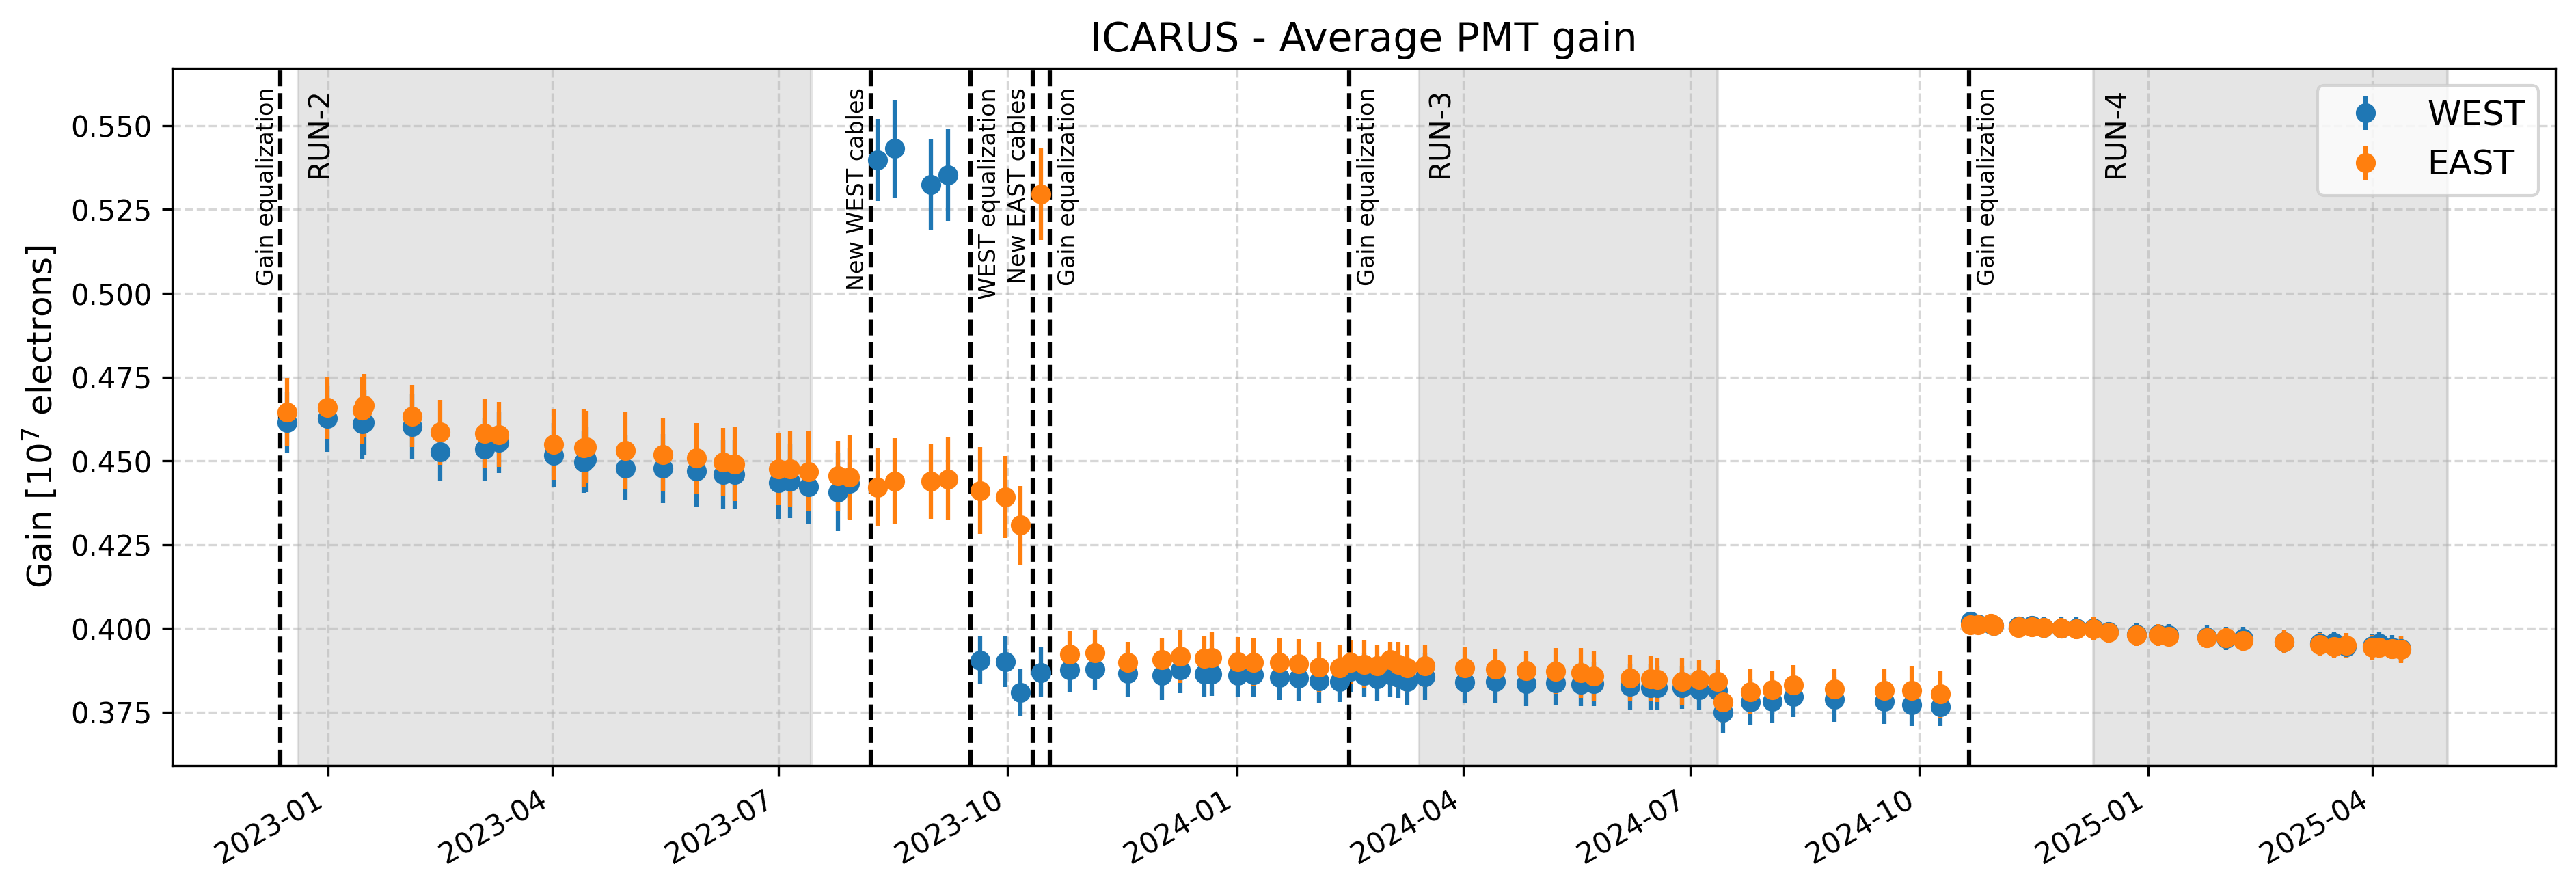

In [84]:
fig = plt.figure(figsize=(15, 5),dpi=300)

plt.errorbar( x=dw.date, y=dw.mean_fit_q, yerr=dw.fit_sigma, fmt='o',label="WEST")
plt.errorbar( x=de.date, y=de.mean_fit_q, yerr=de.fit_sigma, fmt='o',label="EAST")

#for i,r in enumerate(dw.run.to_numpy()):
#    plt.annotate( str(r), xy=(dw.date.to_numpy()[i],dw.mean_fit_q.to_numpy()[i]),textcoords="offset points", xytext=(0,35), ha='center')

#plt.ylim((0.34,0.44))
plt.ylabel("Gain [$10^7$ electrons]", fontsize=12)
plt.title("ICARUS - Average PMT gain", fontsize=14)
plt.grid(alpha=0.5, linestyle="dashed")
#plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right", fontsize=12)
plt.gcf().autofmt_xdate()
plt.legend(fontsize=12)

ytop = plt.gca().get_ylim()[1]  # Get the upper limit of the y-axis

# Run1 
#plt.axvline( x=run1[0], linestyle="dashed",color="black")
#plt.axvline( x=run1[1], linestyle="dashed",color="black")

# Run2
plt.axvline(x=pd.to_datetime("2022-12-13", utc=True).tz_localize(None), linestyle="dashed",color="black")
plt.text(x=pd.to_datetime("2022-12-13", utc=True).tz_localize(None)-timedelta(days=10), y=0.99*ytop, s='Gain equalization', rotation=90,fontsize=8, va="top")
#plt.axvline( x=run2[0], linestyle="dashed",color="black")
#plt.axvline( x=run2[1], linestyle="dashed",color="black")
plt.axvspan(run2[0], run2[1], color="gray", alpha=0.2)
plt.text(x=run2[0]+timedelta(days=3), y=0.99*ytop, s='RUN-2', rotation=90, fontsize=10, va="top")
#plt.text(x=run2[1]+timedelta(days=3), y=0.99*ytop, s='End RUN-2', rotation=90, fontsize=8, va="top")

# Run3
plt.axvline(x=pd.to_datetime("2023-08-07", utc=True).tz_localize(None), linestyle="dashed",color="black")
plt.text(x=pd.to_datetime("2023-08-07", utc=True).tz_localize(None)-timedelta(days=10), y=0.99*ytop, s='New WEST cables', rotation=90,fontsize=8, va="top")
plt.axvline(x=pd.to_datetime("2023-09-16", utc=True).tz_localize(None), linestyle="dashed",color="black")
plt.text(x=pd.to_datetime("2023-09-16", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='WEST equalization', rotation=90,fontsize=8, va="top")
plt.axvline(x=pd.to_datetime("2023-10-11", utc=True).tz_localize(None), linestyle="dashed",color="black")
plt.text(x=pd.to_datetime("2023-10-11", utc=True).tz_localize(None)-timedelta(days=10), y=0.99*ytop, s='New EAST cables', rotation=90,fontsize=8, va="top")
plt.axvline(x=pd.to_datetime("2023-10-18", utc=True).tz_localize(None), linestyle="dashed",color="black")
plt.text(x=pd.to_datetime("2023-10-18", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='Gain equalization', rotation=90,fontsize=8, va="top")
plt.axvline(x=pd.to_datetime("2024-02-15", utc=True).tz_localize(None), linestyle="dashed",color="black")
plt.text(x=pd.to_datetime("2024-02-15", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='Gain equalization', rotation=90,fontsize=8, va="top")
#plt.axvline( x=run3[0], linestyle="dashed",color="black")
#plt.axvline( x=run3[1], linestyle="dashed",color="black")
plt.axvspan(run3[0], run3[1], color="gray", alpha=0.2)
plt.text(x=run3[0]+timedelta(days=3), y=0.99*ytop, s='RUN-3', rotation=90, fontsize=10, va="top")
#plt.text(x=run3[1]+timedelta(days=3), y=0.99*ytop, s='RUN-3', rotation=90, fontsize=8, va="top")

# Run 4
plt.axvline(x=pd.to_datetime("2024-10-21", utc=True).tz_localize(None), linestyle="dashed",color="black")
plt.text(x=pd.to_datetime("2024-10-21", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='Gain equalization', rotation=90,fontsize=8, va="top")
#plt.axvline(x=run4[0], linestyle="dashed",color="black")
plt.axvspan(run4[0], run4[1], color="gray", alpha=0.2)
plt.text(x=run4[0]+timedelta(days=3), y=0.99*ytop, s='RUN-4', rotation=90, fontsize=10, va="top")

name = "figs/ICARUS_Mean_PMT_gain_cryowise"
plt.savefig(name+".pdf",dpi=300)

plt.show()

## Gain by wall

In [85]:
# WEST
dww = data[data.wall=="WW"].groupby(["timestamp","date","run"]).agg(list).reset_index()
dww[["mean_fit_q","fit_sigma","equal","eEqual"]] = dww.apply(lambda x: fitGains(x["q"],x["run"]), axis=1, result_type='expand')

dwe = data[data.wall=="WE"].groupby(["timestamp","date","run"]).agg(list).reset_index()
dwe[["mean_fit_q","fit_sigma","equal","eEqual"]] = dwe.apply(lambda x: fitGains(x["q"],x["run"]), axis=1, result_type='expand')

# EAST
dew = data[data.wall=="EW"].groupby(["timestamp","date","run"]).agg(list).reset_index()
dew[["mean_fit_q","fit_sigma","equal","eEqual"]] = dew.apply(lambda x: fitGains(x["q"],x["run"]), axis=1, result_type='expand')

dee = data[data.wall=="EE"].groupby(["timestamp","date","run"]).agg(list).reset_index()
dee[["mean_fit_q","fit_sigma","equal","eEqual"]] = dee.apply(lambda x: fitGains(x["q"],x["run"]), axis=1, result_type='expand')

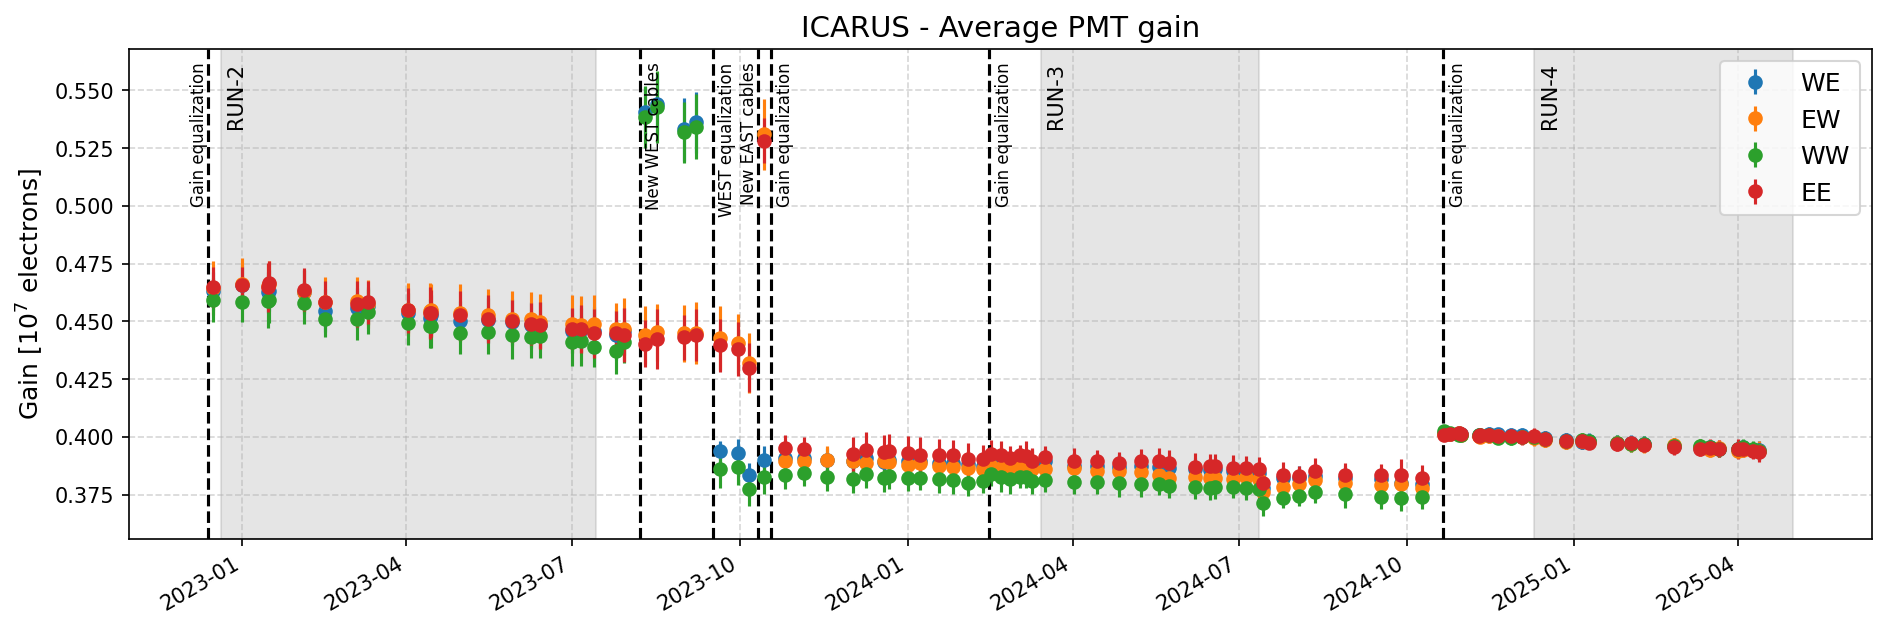

In [86]:
fig = plt.figure(figsize=(15, 4.8),dpi=150)

plt.errorbar( x=dwe.date, y=dwe.mean_fit_q, yerr=dwe.fit_sigma, fmt='o',label="WE")
plt.errorbar( x=dew.date, y=dew.mean_fit_q, yerr=dew.fit_sigma, fmt='o',label="EW")
plt.errorbar( x=dww.date, y=dww.mean_fit_q, yerr=dww.fit_sigma, fmt='o',label="WW")
plt.errorbar( x=dee.date, y=dee.mean_fit_q, yerr=dee.fit_sigma, fmt='o',label="EE")

#for i,r in enumerate(dw.run.to_numpy()):
#    plt.annotate( str(r), xy=(dww.date.to_numpy()[i],dww.mean_fit_q.to_numpy()[i]),textcoords="offset points", xytext=(0,35), ha='center')

#plt.ylim((0.34,0.44))
plt.ylabel("Gain [$10^7$ electrons]", fontsize=12)
plt.title("ICARUS - Average PMT gain", fontsize=14)
plt.grid(alpha=0.5, linestyle="dashed")
#plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right", fontsize=12)
plt.gcf().autofmt_xdate()
plt.legend(fontsize=12, ncol=1)

ytop = plt.gca().get_ylim()[1]  # Get the upper limit of the y-axis

# Run1 
#plt.axvline( x=run1[0], linestyle="dashed",color="black")
#plt.axvline( x=run1[1], linestyle="dashed",color="black")

# Run2
plt.axvline(x=pd.to_datetime("2022-12-13", utc=True).tz_localize(None), linestyle="dashed",color="black")
plt.text(x=pd.to_datetime("2022-12-13", utc=True).tz_localize(None)-timedelta(days=10), y=0.99*ytop, s='Gain equalization', rotation=90,fontsize=8, va="top")
#plt.axvline( x=run2[0], linestyle="dashed",color="black")
#plt.axvline( x=run2[1], linestyle="dashed",color="black")
plt.axvspan(run2[0], run2[1], color="gray", alpha=0.2)
plt.text(x=run2[0]+timedelta(days=3), y=0.99*ytop, s='RUN-2', rotation=90, fontsize=10, va="top")
#plt.text(x=run2[1]+timedelta(days=3), y=0.99*ytop, s='End RUN-2', rotation=90, fontsize=8, va="top")

# Run3
plt.axvline(x=pd.to_datetime("2023-08-07", utc=True).tz_localize(None), linestyle="dashed",color="black")
plt.text(x=pd.to_datetime("2023-08-07", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='New WEST cables', rotation=90,fontsize=8, va="top")
plt.axvline(x=pd.to_datetime("2023-09-16", utc=True).tz_localize(None), linestyle="dashed",color="black")
plt.text(x=pd.to_datetime("2023-09-16", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='WEST equalization', rotation=90,fontsize=8, va="top")
plt.axvline(x=pd.to_datetime("2023-10-11", utc=True).tz_localize(None), linestyle="dashed",color="black")
plt.text(x=pd.to_datetime("2023-10-11", utc=True).tz_localize(None)-timedelta(days=10), y=0.99*ytop, s='New EAST cables', rotation=90,fontsize=8, va="top")
plt.axvline(x=pd.to_datetime("2023-10-18", utc=True).tz_localize(None), linestyle="dashed",color="black")
plt.text(x=pd.to_datetime("2023-10-18", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='Gain equalization', rotation=90,fontsize=8, va="top")
plt.axvline(x=pd.to_datetime("2024-02-15", utc=True).tz_localize(None), linestyle="dashed",color="black")
plt.text(x=pd.to_datetime("2024-02-15", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='Gain equalization', rotation=90,fontsize=8, va="top")
#plt.axvline( x=run3[0], linestyle="dashed",color="black")
#plt.axvline( x=run3[1], linestyle="dashed",color="black")
plt.axvspan(run3[0], run3[1], color="gray", alpha=0.2)
plt.text(x=run3[0]+timedelta(days=3), y=0.99*ytop, s='RUN-3', rotation=90, fontsize=10, va="top")
#plt.text(x=run3[1]+timedelta(days=3), y=0.99*ytop, s='RUN-3', rotation=90, fontsize=8, va="top")

# Run 4
plt.axvline(x=pd.to_datetime("2024-10-21", utc=True).tz_localize(None), linestyle="dashed",color="black")
plt.text(x=pd.to_datetime("2024-10-21", utc=True).tz_localize(None)+timedelta(days=3), y=0.99*ytop, s='Gain equalization', rotation=90,fontsize=8, va="top")
#plt.axvline(x=run4[0], linestyle="dashed",color="black")
plt.axvspan(run4[0], run4[1], color="gray", alpha=0.2)
plt.text(x=run4[0]+timedelta(days=3), y=0.99*ytop, s='RUN-4', rotation=90, fontsize=10, va="top")

name = "figs/ICARUS_Mean_PMT_gain_wallwise"
plt.savefig(name+".pdf",dpi=300)

plt.show()